# Bayesian Accelerated Randomized Benchmarking

## One-Qubit Interleaved RB on Simulator

This is a bayesian pyMC3 implementation on top of frequentist interleaved RB from qiskit experiments

Based on the tutorial [randomized_benchmarking](https://github.com/Qiskit/qiskit-experiments/blob/main/docs/tutorials/randomized_benchmarking.ipynb) of qiskit experiments

The Bayesian sequential Monte Carlo (SMC) algorithms are based on equation 13 in [this paper](https://arxiv.org/abs/1802.00401) by Hincks et al.
The SMC model is based on equations 3,4 and 5 in [this paper](https://arxiv.org/abs/1404.5275) by Granade and al.

This demo shows that accelerated SMC delivers on simulator precise estimations of the error per Clifford, with narrow error bounds.

In [1]:
import numpy as np
import time
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library.randomized_benchmarking import RBUtils
import qiskit.circuit.library as circuits

# for retrieving gate  Reference
from datetime import datetime
import qiskit.providers.aer.noise.device as dv

# import the bayesian packages
import pymc3 as pm
import arviz as az
import qiskit_bayesian_fitter as bf

In [3]:
simulation = True # make your choice here
if simulation:
    from qiskit.providers.aer import AerSimulator
    from qiskit.test.mock import FakeParis
    backend = AerSimulator.from_backend(FakeParis())
else:
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = provider.get_backend('ibmq_bogota') # type here hardware backend  

## one or two-qubit interleaved RB

In [4]:
# describe RB experiment (accept 1-qubit or 2-qubit interleaved gate)
is_1_qubit = True
if is_1_qubit:
    interleaved_gate = "x"
    interleaved_circuit = circuits.XGate()
    qubits = [0]
    lengths = np.arange(1, 2500, 250)
    testval_s = 0.001
    upper_s = 0.004
    lower_s = 0.0005
    alpha_Gamma = 10
    beta_Gamma = 10000
else:
    interleaved_gate = "cx"
    interleaved_circuit = circuits.CXGate()
    qubits = [1,4]
    lengths = np.arange(1, 200, 15)
    testval_s = 0.0025
    upper_s = 0.005
    lower_s = 0.0005
    alpha_Gamma = 5
    beta_Gamma = 2000
num_samples = 10
seed = 194606

In [5]:
# get the backend's referencevalue
t = None # enter t in datetime format if necessary
# use properties(datetime=t) if t is defined
e_list = dv.gate_error_values(backend.properties()) 
epc_calib = np.nan
for tuple_e in e_list:
    if tuple_e[0] == interleaved_gate and tuple_e[1] == qubits:
        epc_calib = tuple_e[2]
print('EPC reference:    {0:1.4e}'.format(epc_calib)) 

EPC reference:    4.4321e-04


### Prepare and run circuits using Qiskit experiments

In [6]:
#prepare circuits
int_exp = InterleavedRB(interleaved_circuit, qubits,
                            lengths, num_samples=num_samples, seed=seed)
#run
print("start experiments",time.strftime('%d/%m/%Y %H:%M:%S'))
int_expdata = int_exp.run(backend).block_for_results()
print("  end experiments",time.strftime('%d/%m/%Y %H:%M:%S'))

start experiments 30/08/2021 22:21:32
  end experiments 30/08/2021 22:26:36


   ### prepare for SMC

In [8]:
experiment_type = int_expdata._data[0]['metadata']['experiment_type']
physical_qubits = int_expdata._data[0]['metadata']['physical_qubits']
shots = int_expdata._data[0]['shots']
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
m_len = len(lengths)

In [9]:
# get count data and other values from int_expdata
Y = bf.get_GSP_counts(int_expdata._data, 2*m_len,
                    range(num_samples))

In [10]:
# get RvsI_h and IvsR_h
RvsI_h = np.ones(2*m_len) 
for i_data in range(2*m_len):
    if int_expdata._data[i_data]['metadata']['interleaved']:
            RvsI_h[i_data] = 0.  
IvsR_h = (RvsI_h + 1.) %2

In [11]:
X0 = np.tile(lengths,2)
X = np.vstack((X0,RvsI_h,IvsR_h))
y_mean = np.mean(Y, axis = 0)/shots
sigma_y = np.std(Y, axis = 0)/shots

###  Serial Monte Carlo, hierarchical model

Model based on: equations 3, 4 and 5 in [this paper](https://arxiv.org/abs/1404.5275) by Granade et al. and equation 13 in [this paper](https://arxiv.org/abs/1802.00401) by Hincks et al.

A good introduction to model creation and inference using PyMC3 can be found here: [General API quickstart — PyMC3 3.11.2 documentation](https://docs.pymc.io/pymc-examples/examples/pymc3_howto/api_quickstart.html).

In [12]:
model = "hierarchical model"

In [13]:
# priors for unknown model parameters
T_priors = int_expdata.analysis_results()[0].value.value
print(T_priors)

[0.47676853 0.99829339 0.99913555 0.51035524]


In [14]:
h_model = bf.create_model(T_priors, X, Y, shots, scale,
                          testval_s = testval_s, upper_s = upper_s, lower_s = lower_s,
                          s_prior = "Gamma", alpha_Gamma = alpha_Gamma, beta_Gamma = beta_Gamma)

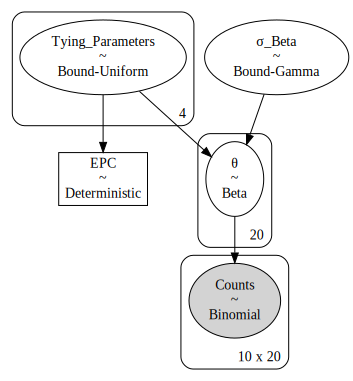

In [15]:
# model graph                                
pm.model_to_graphviz(h_model)

In [16]:
# sample
with h_model:
    trace_h = pm.sample(draws = 4000, tune= 1000, target_accept=.99,
                         return_inferencedata=True)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ_Beta, Tying_Parameters]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 293 seconds.
The number of effective samples is smaller than 25% for some parameters.


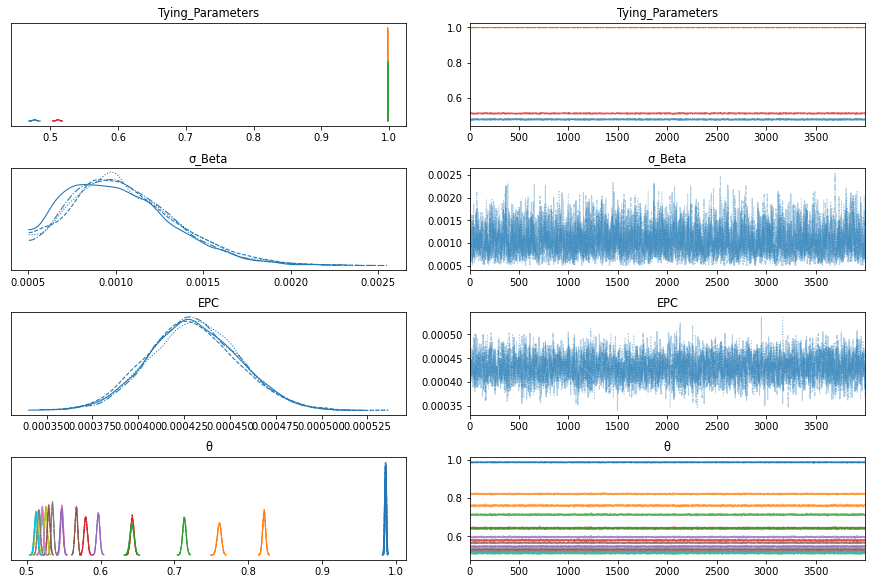

In [17]:
with h_model:
        az.plot_trace(trace_h);

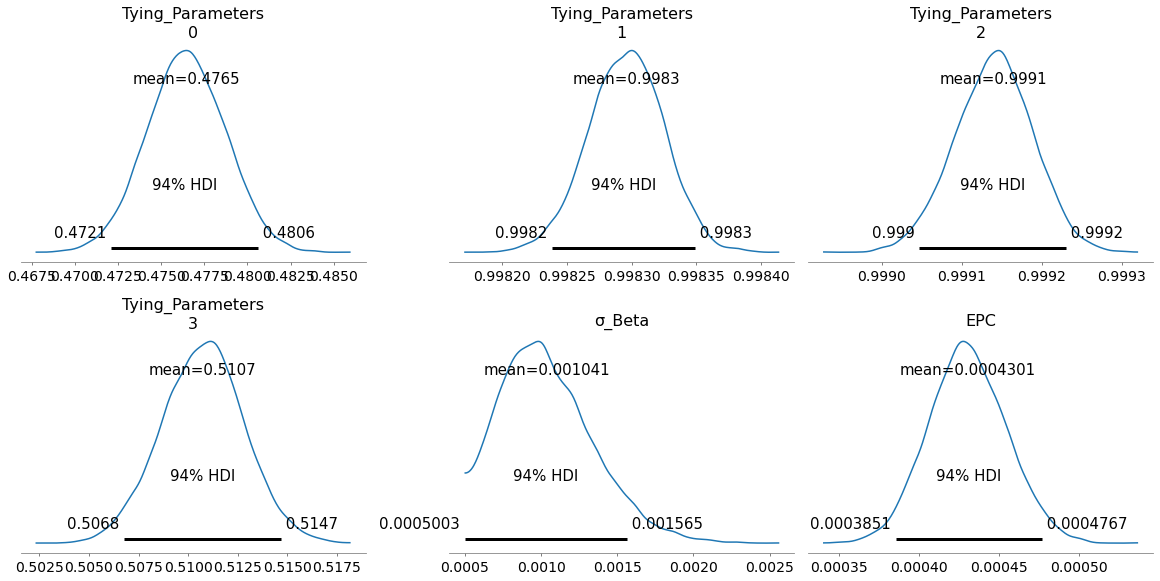

In [18]:
with h_model:
    az.plot_posterior(trace_h, var_names = ["Tying_Parameters","σ_Beta","EPC"], round_to = 4, figsize = [16, 8]);

In [43]:
# look at the posterior values of the hyperparameters:
with h_model:
    #  (hdi_prob=.94 is default)
    azt_summary = az.summary(trace_h, round_to=12,                            
                             var_names = ["Tying_Parameters","σ_Beta","EPC"],
                             kind="stats")
azt_summary

,mean,sd,hdi_3%,hdi_97%
Tying_Parameters[0],0.476468,0.002274,0.472091,0.480619
Tying_Parameters[1],0.998296,0.000029,0.998238,0.998349
Tying_Parameters[2],0.999140,0.000049,0.999047,0.999230
Tying_Parameters[3],0.510739,0.002082,0.506766,0.514654
σ_Beta,0.001041,0.000306,0.000500,0.001565
EPC,0.000430,0.000024,0.000385,0.000477


In [20]:
# for comparison
# bayesian
epc_est_a = azt_summary['mean']['EPC']
epc_est_a_err = azt_summary['sd']['EPC']
# frequentist
epc_est_fm = int_expdata.analysis_results()[3].value.value
epc_est_fm_err = int_expdata.analysis_results()[3].value.stderr

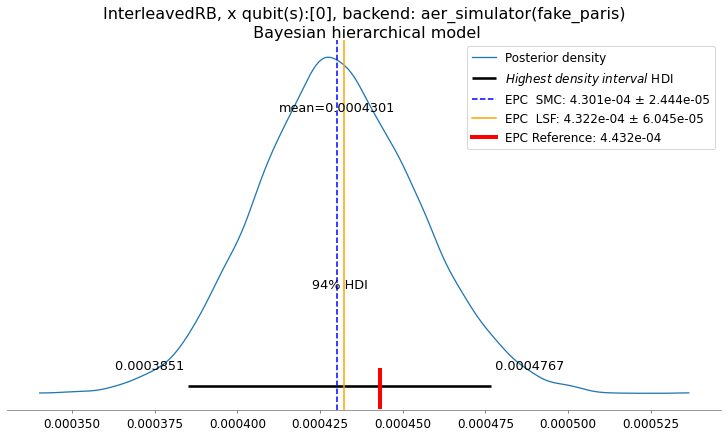

In [22]:
epc_title = experiment_type +', ' + interleaved_gate  \
            + " qubit(s):" + str(physical_qubits)\
            +', backend: '+ backend.name() + "\n Bayesian "+model
bf.plot_epc(h_model, trace_h, epc_calib, epc_est_a,
             epc_est_a_err, epc_est_fm, epc_est_fm_err, epc_title)

In [23]:
# compare LSF and SMC

print("Model:    Frequentist         Bayesian         Reference")
print("__________________________________________________________")
print("EPC         {0:1.3e}        {1:1.3e}         {2:1.3e}"
      .format(epc_est_fm,epc_est_a,epc_calib ))  
print("± sd       ± {0:1.3e}      ± {1:1.3e} "
      .format(epc_est_fm_err, epc_est_a_err))

Model:    Frequentist         Bayesian         Reference
__________________________________________________________
EPC         4.322e-04        4.301e-04         4.432e-04
± sd       ± 6.045e-05      ± 2.444e-05 


#### routine for computing  the optimized function based on this [document](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html):

In [24]:
def calc_chisquare(ydata, sigma, ycalc): 
    r = ydata - ycalc
    chisq = np.sum((r / sigma) ** 2)
    return chisq

### GSP plot

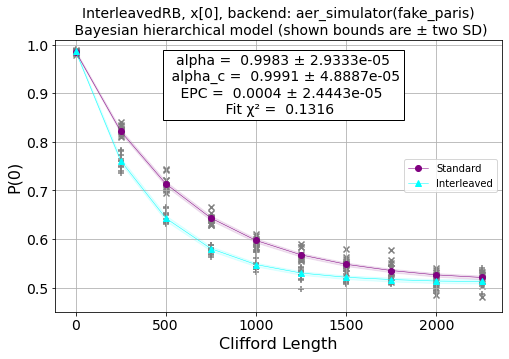

In [25]:
# GSP plot

# perform reduced χ² value calculation for Bayes hierarchical 
mean_h = trace_h.posterior.mean(dim=['chain', 'draw'])
theta_stacked = mean_h.θ.values
NDF_h = m_len*2 - 4 - 1 # (-1 is for σ_Beta)
chisq_h = calc_chisquare(y_mean, sigma_y, theta_stacked)/NDF_h

#box:
texto = "  alpha = {0:7.4f} ± {1:1.4e}"\
            .format(azt_summary['mean']['Tying_Parameters[1]'],
            azt_summary['sd']['Tying_Parameters[1]']) + "\n"                                          

texto +=" alpha_c = {0:7.4f} ± {1:1.4e}"\
            .format(azt_summary['mean']['Tying_Parameters[2]'],
            azt_summary['sd']['Tying_Parameters[2]']) + "\n"                                             

texto +="   EPC = {0:7.4f} ± {1:1.4e}"\
            .format(azt_summary['mean']['EPC'],
            azt_summary['sd']['EPC']) + "\n"

texto +="             Fit χ² = {0:7.4f} "\
            .format(chisq_h)

# obtain data for plot
bounds_rmk, y1, y1_min, y1_max, y2, y2_min, y2_max, Y1, Y2 = \
  bf.prepare_two_curves_GSP_plot(h_model, trace_h, X, Y, HDI = False)

# title
title = experiment_type +', ' + interleaved_gate\
          + str(physical_qubits)\
          +', backend: '+backend.name()+\
          "\n Bayesian "+model+" "+ bounds_rmk
# plot
bf.gsp_plot(scale, lengths, num_samples, shots, texto, title,
         y1, y1_min, y1_max, y2, y2_min, y2_max, Y1, Y2,
         first_curve = "Standard", second_curve = "Interleaved")

#### compare with frequentist model results

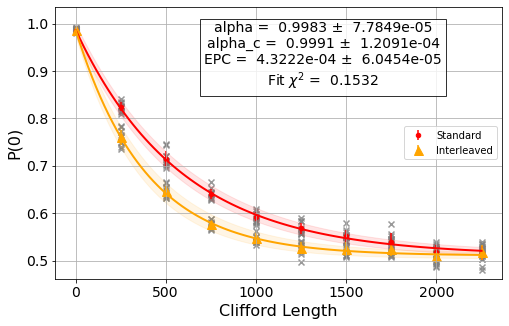

In [26]:
# View result  for frequentist model
display(int_expdata.figure(0))